## Zillow Housing Data Time Series Projections

## Setup

In [1]:
import pandas as pd
import matplotlib
import numpy as np
from sklearn import metrics

%load_ext autoreload
%autoreload 2

import itertools
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys
sys.path.insert(0, '../code')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',400)

from code.functions import *

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

Functions loaded.


# EDA

## Load Data

Load 1-bedroom and 2-bedroom home value data, sourced from Zillow Research.

In [2]:
df_1_bd = pd.read_csv('data/Zip_zhvi_bdrmcnt_1_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')
df_2_bd = pd.read_csv('data/Zip_zhvi_bdrmcnt_2_uc_sfrcondo_tier_0.33_0.67_sm_sa_mon.csv')

Extract San Franciso data.

In [3]:
df_1_bd = df_1_bd[df_1_bd.CountyName == 'San Francisco County']
df_2_bd = df_2_bd[df_2_bd.CountyName == 'San Francisco County']

Check the shape of the datasets.

In [4]:
print("Shape of 1 Bedroom dataset for San Franciso is ", df_1_bd.shape)
print("Shape of 2 Bedroom dataset for San Franciso is ", df_2_bd.shape)

Shape of 1 Bedroom dataset for San Franciso is  (25, 311)
Shape of 2 Bedroom dataset for San Franciso is  (25, 311)


In [5]:
df_1_bd.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
12,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,260256.0,259464.0,259741.0,260283.0,261841.0,263092.0,264205.0,265654.0,266982.0,268514.0,269250.0,270052.0,270706.0,272850.0,275068.0,276733.0,277569.0,279036.0,281145.0,282877.0,285615.0,288679.0,293228.0,297098.0,301854.0,306116.0,309977.0,314039.0,317579.0,321445.0,325343.0,329714.0,333798.0,337336.0,340579.0,344750.0,348166.0,351846.0,355766.0,360417.0,365214.0,369852.0,374002.0,378475.0,381427.0,384832.0,389269.0,396378.0,404187.0,412214.0,419917.0,427510.0,435351.0,444464.0,455477.0,466187.0,47

In [6]:
df_2_bd.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
13,97564,13,94109,Zip,CA,CA,San Francisco,San Francisco-Oakland-Hayward,San Francisco County,395027.0,392274.0,391226.0,388511.0,386522.0,384656.0,383879.0,384905.0,387166.0,389492.0,392773.0,396437.0,401525.0,407460.0,412096.0,416288.0,421565.0,427768.0,433598.0,436851.0,439971.0,443803.0,447826.0,451208.0,454305.0,457637.0,462311.0,468395.0,473483.0,479751.0,485969.0,494312.0,500605.0,507084.0,511696.0,518599.0,524303.0,532287.0,540316.0,547897.0,554617.0,558807.0,563294.0,567268.0,574107.0,582571.0,593726.0,604296.0,613443.0,621085.0,630357.0,644173.0,658651.0,672761.0,684941.0,698422.0,71

Check that both datasets have the same columns names for all 311 columns.

In [7]:
(df_1_bd.columns == df_2_bd.columns).sum()

311

## Data Exploration

Check for missing values

In [8]:
df_1_bd.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
             ..
2020-10-31    0
2020-11-30    0
2020-12-31    0
2021-01-31    0
2021-02-28    0
Length: 311, dtype: int64

In [9]:
df_2_bd.isna().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
             ..
2020-10-31    0
2020-11-30    0
2020-12-31    0
2021-01-31    0
2021-02-28    0
Length: 311, dtype: int64

In [10]:
df_1_bd.describe()

,RegionID,SizeRank,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
count,25.000000,25.000000,25.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.00000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0

In [11]:
df_2_bd.describe()

,RegionID,SizeRank,RegionName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,1997-09-30,1997-10-31,1997-11-30,1997-12-31,1998-01-31,1998-02-28,1998-03-31,1998-04-30,1998-05-31,1998-06-30,1998-07-31,1998-08-31,1998-09-30,1998-10-31,1998-11-30,1998-12-31,1999-01-31,1999-02-28,1999-03-31,1999-04-30,1999-05-31,1999-06-30,1999-07-31,1999-08-31,1999-09-30,1999-10-31,1999-11-30,1999-12-31,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28
count,25.000000,25.000000,25.000000,22.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23

## Reshape DataFrame

In order to run time series analysis, we must reshape our DataFrame from Wide to Long Format.

In [12]:
df_1_melt = melt_data(df_1_bd)
df_2_melt = melt_data(df_2_bd)
columns = ['RegionName', 'date', 'value']
df_1 = df_1_melt[columns]
df_2 = df_2_melt[columns]
df_1.columns = ['zipcode', 'date', 'value']
df_2.columns = ['zipcode', 'date', 'value']

In [13]:
df_1.head()

,zipcode,date,value
0,94109,1996-01-31,260256.0
1,94110,1996-01-31,217471.0
2,94122,1996-01-31,288096.0
3,94112,1996-01-31,204717.0
4,94115,1996-01-31,218208.0


In [14]:
df_2.head()

,zipcode,date,value
0,94109,1996-01-31,395027.0
1,94110,1996-01-31,244323.0
2,94122,1996-01-31,270792.0
3,94112,1996-01-31,226713.0
4,94115,1996-01-31,304296.0


Check for number of observations in each zip code.

In [15]:
df_1.zipcode.value_counts()

94105    302
94111    302
94134    302
94122    302
94118    302
94114    302
94110    302
94102    302
94131    302
94127    302
94123    302
94115    302
94107    302
94109    302
94103    302
94132    302
94124    302
94116    302
94112    302
94108    302
94133    302
94121    302
94117    302
94104    231
94158    158
Name: zipcode, dtype: int64

In [16]:
df_2.zipcode.value_counts()

94107    302
94122    302
94114    302
94110    302
94102    302
94131    302
94127    302
94123    302
94115    302
94111    302
94109    302
94103    302
94132    302
94124    302
94116    302
94112    302
94108    302
94134    302
94133    302
94121    302
94117    302
94118    302
94105    301
94158    194
94104    176
Name: zipcode, dtype: int64

Check that that zip codes match.

In [17]:
(set(df_1.zipcode) - set(df_2.zipcode))

set()

Create separate DataFrames for 1-bedroom homes and 2-bedroom homes averaged across zip codes.

In [18]:
sf_1_all = df_1.groupby('date').aggregate({'value':'mean'})
sf_2_all = df_2.groupby('date').aggregate({'value':'mean'})

In [19]:
sf_1_all.head()

,value
date,
1996-01-31,252714.043478
1996-02-29,252364.478261
1996-03-31,251782.391304
1996-04-30,251039.652174
1996-05-31,250138.260870


In [20]:
sf_2_all.head()

,value
date,
1996-01-31,309948.545455
1996-02-29,312421.913043
1996-03-31,311953.086957
1996-04-30,310741.173913
1996-05-31,310157.652174


## Visualization

Plot times series for each all zip codes as well for all zip codes averaged for 1-bedroom and 2-bedroom home values.

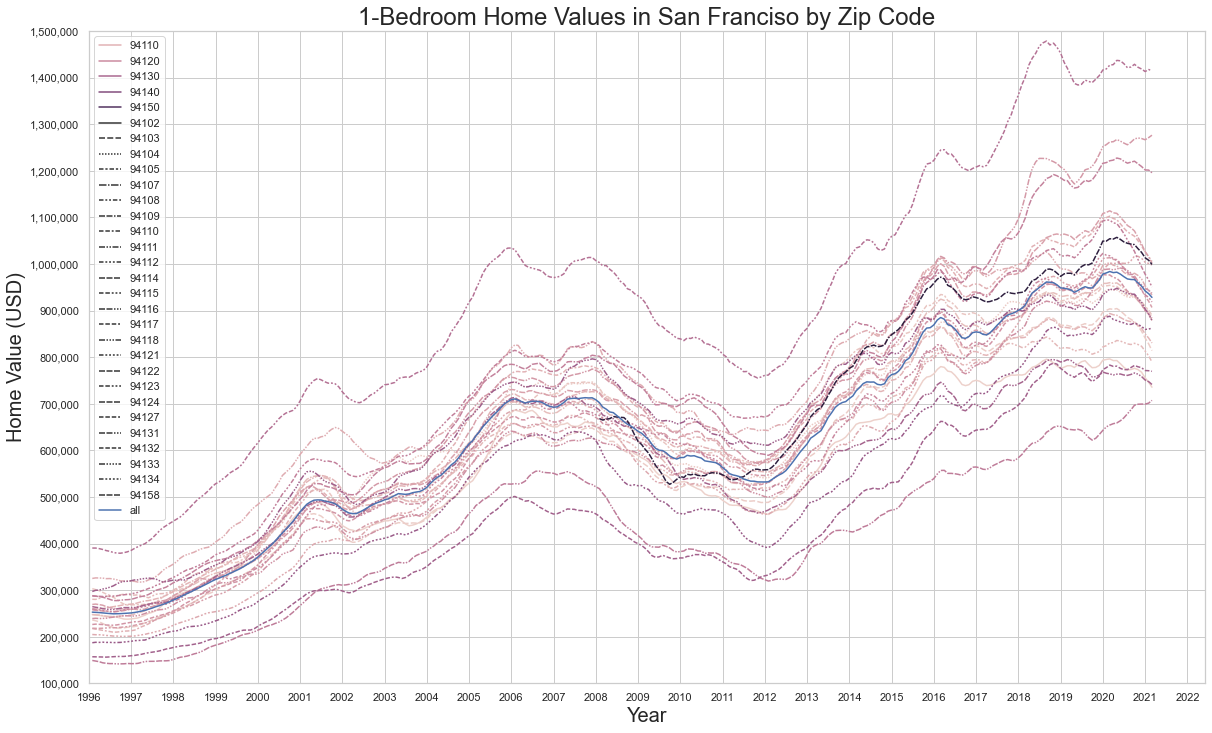

In [21]:
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('1-Bedroom Home Values in San Franciso by Zip Code', size=24)
sns.lineplot(data=df_1, x=df_1.date, y=df_1.value, ax=ax, hue='zipcode', style='zipcode')
sns.lineplot(data=sf_1_all, x=sf_1_all.index, y=sf_1_all.value, ax=ax, color = 'b', label='all')
ax.set_xlabel('Year',  size=20)
ax.set_ylabel('Home Value (USD)', size=20)
ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.set_yticks(np.linspace(1e5,1.5e6,15))
ax.set_ylim((1e5, 1.5e6))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('images/1_bdrm_home_values.png')

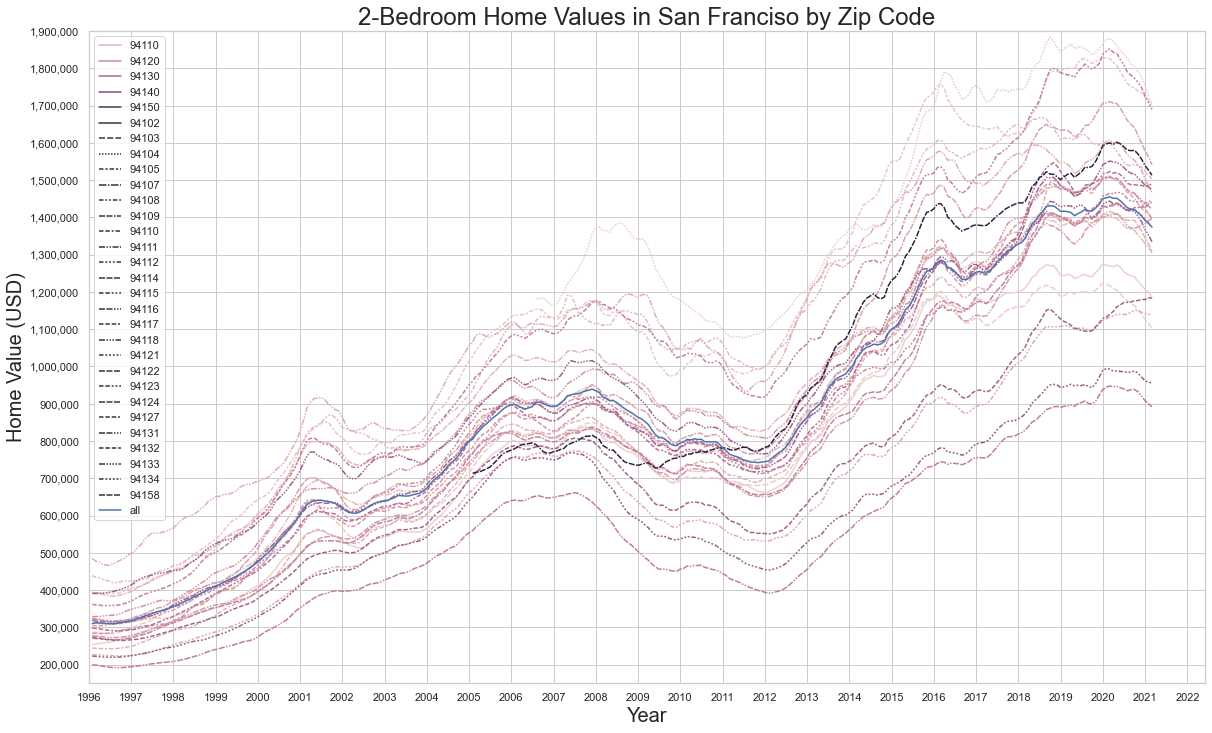

In [22]:
fig, ax = plt.subplots(figsize=(20,12))
ax.set_title('2-Bedroom Home Values in San Franciso by Zip Code', size=24)
sns.lineplot(data=df_2, x=df_2.date, y=df_2.value, ax=ax, hue='zipcode', style='zipcode')
sns.lineplot(data=sf_2_all, x=sf_2_all.index, y=sf_2_all.value, ax=ax, color = 'b', label='all')
ax.set_xlabel('Year',  size=20)
ax.set_ylabel('Home Value (USD)', size=20)
ax.set_xlim(pd.Timestamp('1996'), pd.Timestamp('2022-05-31'))
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.set_yticks(np.linspace(2e5,1.9e6,18))
ax.set_ylim((1.5e5, 1.9e6))
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig('images/2_bdrm_home_values.png')

# Data Prep

## Prepare Data Structure

Create dictionary data structures with keys as zip codes and values as time series.

In [27]:
sf_1_dict = create_df_dict(df_1)
sf_2_dict = create_df_dict(df_2)

## Test Stationarity

### 1-Bedroom Home Values

Test stationarity for 1-bedroom home values, undifferenced. We see that the p-value is above 0.05, meaning this does not pass the test.

In [33]:
test_stationarity(sf_1_all)

Test Statistic                  -1.793011
p-value                          0.383937
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


Test stationarity for 1-bedroom home values, differenced once. We see that the p-value is still above 0.05.

In [35]:
test_stationarity(sf_1_all, 1)

Test Statistic                  -2.316876
p-value                          0.166583
#Lags Used                      15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


Test stationarity for 1-bedroom home values, differenced twice. We see that the p-value is below 0.05, which passes the test.

In [36]:
test_stationarity(sf_1_all, 2)

Test Statistic                -7.097080e+00
p-value                        4.261762e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


Check that all zip codes pass the test if differenced twice.

In [37]:
test_stationarity_all_zips(sf_1_dict, 2)

0.1926145455165832
0.2060422729459903
0.28775511977713875
0.07993566297172833
0.12863966926350828
0.09891970954011631
0.08290320249362182
0.3111836117777681
0.13715105283198115
0.14637328895676732
0.17271856642597144
0.1337574409333543
0.06464975186815168
0.09976068994950421
0.07803295357584289
0.3662963961134048
0.10228118941553666
0.28197131317300095
0.08767823497608018
0.07952584152580128
0.17592392816866875
0.16263008723813865
0.04817661237234456
0.2480195401331708
0.09750369141922782
1.0599778975079152e-10
3.741464132790946e-09
2.3729847439580716e-06
2.0929714720663458e-08
1.0200049818308661e-08
8.756177530210159e-09
1.0585564028994617e-10
2.8366739299059573e-11
1.8755930836472323e-08
2.983599222687353e-06
1.4626119295937968e-05
4.984964071457166e-11
1.4867341484506552e-12
1.3012300113850876e-10
1.3349107506832198e-13
2.5766985124870837e-06
3.304531327481468e-11
4.84227162460841e-06
6.533571835152499e-08
1.2275721154980474e-11
2.394469222712887e-10
5.3200248248897185e-06
1.8117342

### 2-Bedroom Home Values

Test stationarity for 2-bedroom home values, undifferenced. We see that the p-value is above 0.05, meaning this does not pass the test.

In [38]:
test_stationarity(sf_2_all)

Test Statistic                  -1.400165
p-value                          0.582197
#Lags Used                      16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64


Test stationarity for 2-bedroom home values, differenced once. We see that the p-value is still above 0.05.

In [ ]:
test_stationarity(sf_2_all, 1)

Test stationarity for 2-bedroom home values, differenced twice. We see that the p-value is below 0.05, which passes the test.

In [40]:
test_stationarity(sf_2_all, 2) 

Test Statistic                -6.661065e+00
p-value                        4.845806e-09
#Lags Used                     1.400000e+01
Number of Observations Used    2.850000e+02
Critical Value (1%)           -3.453505e+00
Critical Value (5%)           -2.871735e+00
Critical Value (10%)          -2.572202e+00
dtype: float64


Check that all zip codes pass the test if differenced twice.

In [42]:
test_stationarity_all_zips(sf_2_dict, 2)

0.2229988866563588
0.20341818104256465
0.24390284407782337
0.030833635274431278
0.12383926158723568
0.07283425733482167
0.19879946976070362
0.11240533490243582
0.08577133012198046
0.16711867703126432
0.2127939064194314
0.16509636409843742
0.05097122573040681
0.15619218111390498
0.07190436345815086
0.25625231439948004
0.029105514316216642
0.2677355065731407
0.1442688188097958
0.02175184603117924
0.09244256234062642
0.031485249237360576
0.12534484435935578
0.17940667945630767
0.5028144750781229
2.8382629098311306e-10
4.105094397739434e-10
0.0001036199036005712
0.00026676677750230124
2.3473022836333186e-08
3.3335544220559767e-10
2.6545006217420434e-09
0.00026771357306753607
4.956780761113351e-06
2.716569237155872e-10
3.2762403314473923e-10
1.84499064469341e-11
2.296287426065445e-11
6.379337366664813e-12
6.65319394872682e-13
1.731984377391829e-05
1.3969195940414835e-09
6.410154732169535e-11
1.2892163548319115e-05
1.3300093369712271e-09
6.493273247722747e-11
1.3110838236452227e-08
8.4769764

## Plot ACF and PACF

### 1-Bedroom Home Values

Plot Partial Autocorrelation with undifferenced and differenced data. This suggests an AR term of up to 2.

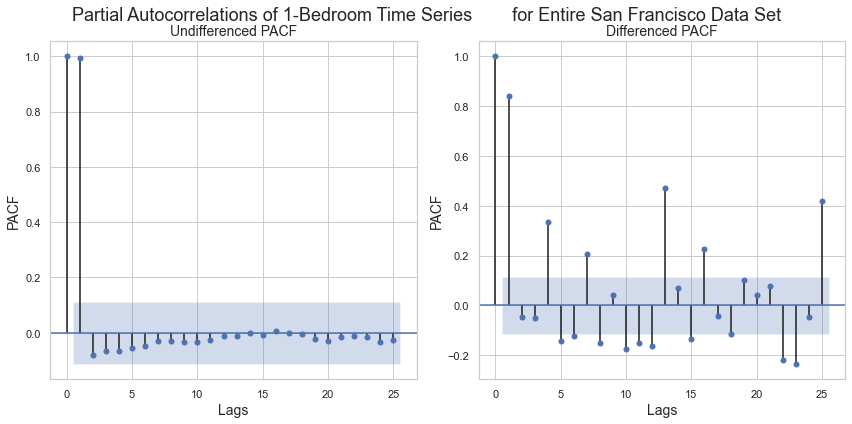

In [43]:
plot_pacf_housing(sf_1_all, 1)

Plot Autocorrelation with undifferenced, once-differenced, and twice-differenced data. This suggests MA terms of up to 2, and difference term of 2.

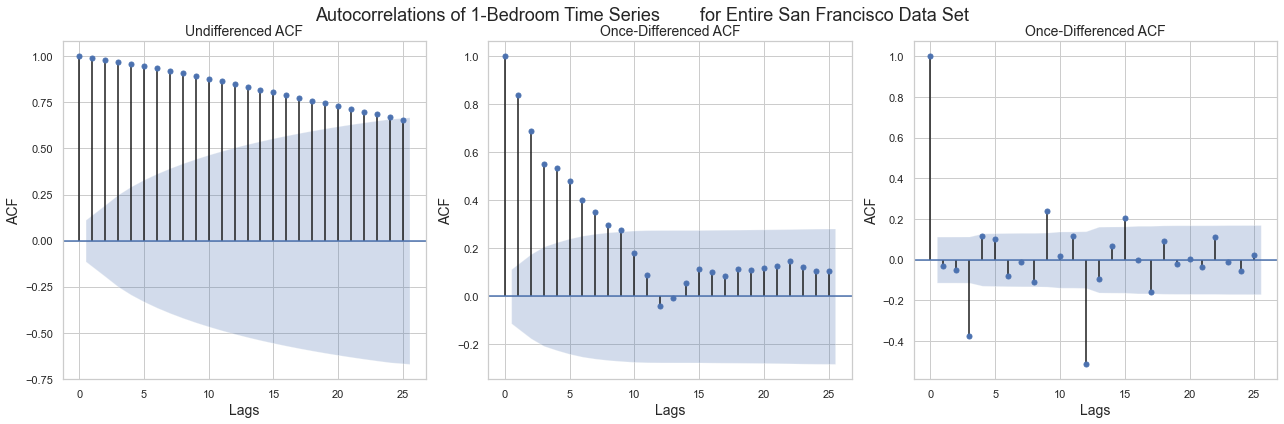

In [44]:
plot_acf_housing(sf_1_all, 1)

### 2-Bedroom Home Values

Plot Partial Autocorrelation with undifferenced and differenced data. This suggests an AR term of up to 2.

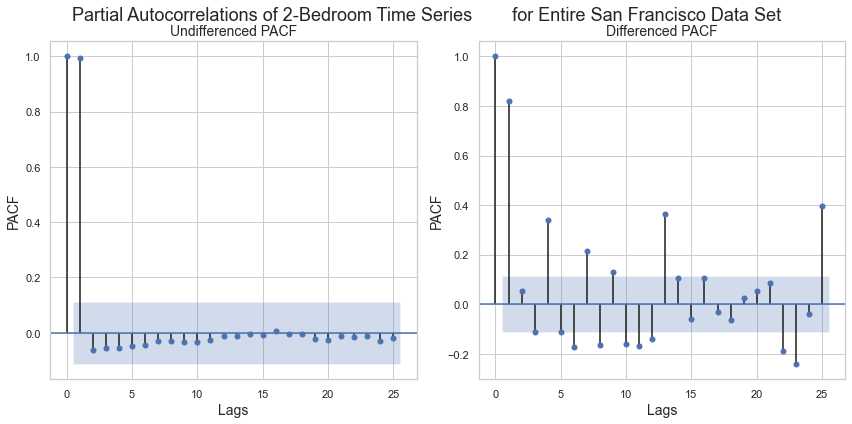

In [45]:
plot_pacf_housing(sf_2_all, 2)

Plot Autocorrelation with undifferenced, once-differenced, and twice-differenced data. This suggests MA terms of up to 2, and difference term of 2.

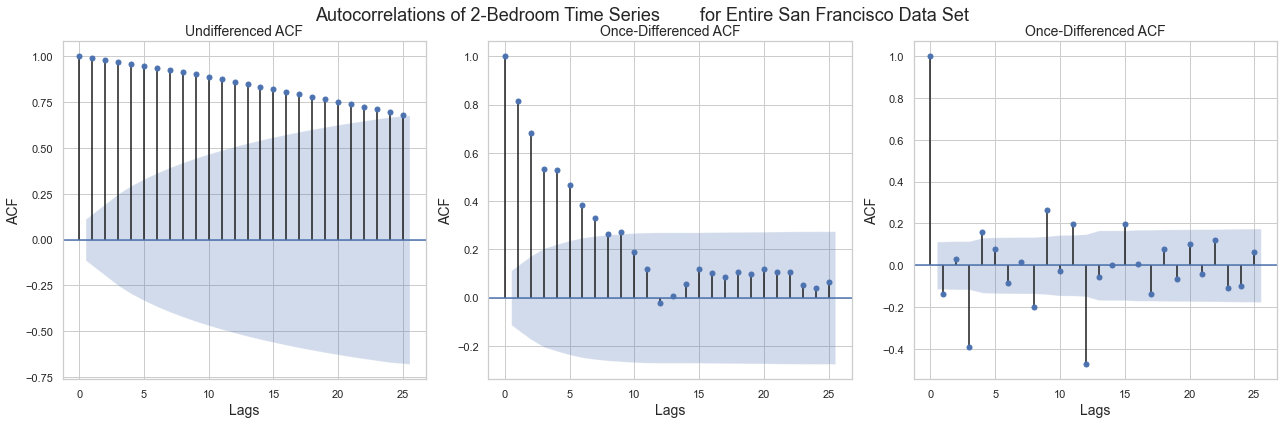

In [46]:
plot_acf_housing(sf_2_all, 2)

## Plot Seasonal Decomposition

### 1-Bedroom Home Values

Plot seasonal decompositions of our 1-bedroom home values. We see a rising trend and 12-month seasonality.

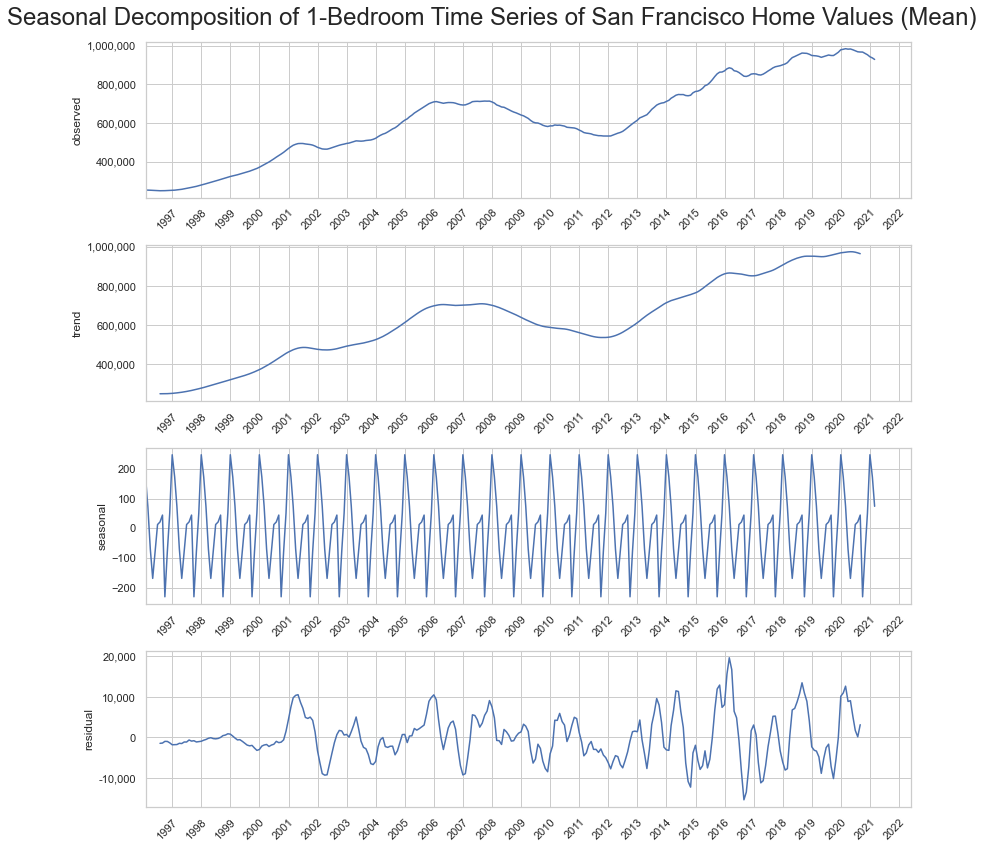

In [47]:
plot_seasonal_decomposition(sf_1_all, 1)

### 2-Bedroom Home Values

Plot seasonal decompositions of our 2-bedroom home values. We see a rising trend and 12-month seasonality.

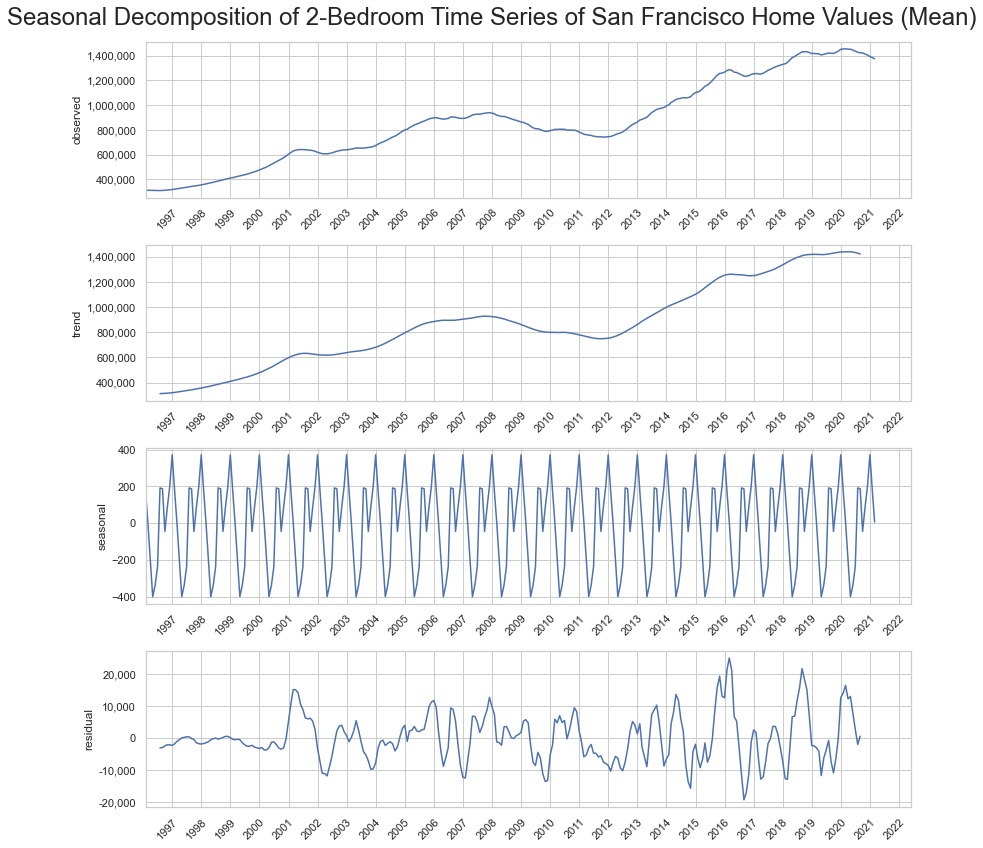

In [49]:
plot_seasonal_decomposition(sf_2_all, 2)

# ARIMA Modeling

## Perform Train-Test Split

Perform a train-test split using `84/16` split. Chosen to give the most recent 4 years as test set.  
Also tested with `76/24` (6 years test set) and `80/20` (5 years test set), but `84/16` gave the best RMSEs.

In [52]:
sf_1_train_dict, sf_1_test_dict = train_test_split_housing(sf_1_dict, 84)
sf_2_train_dict, sf_2_test_dict = train_test_split_housing(sf_2_dict, 84)

Using a 84/16 train-test split...
Using a 84/16 train-test split...


## Manual GridSearch of Model Parameters

Test p, d, q ranging from 1 to 2 for both ARIMA and SARIMA parameters, with 12 month seasonality.

In [ ]:
zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list = gridsearch_SARIMAX(sf_1_train_dict)
zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list = gridsearch_SARIMAX(sf_1_train_dict)

Parameters for SARIMAX grid search...
SARIMAX: (2, 1, 1) x (2, 1, 1, 12)
SARIMAX: (2, 1, 1) x (2, 1, 2, 12)
SARIMAX: (2, 1, 1) x (2, 2, 1, 12)
SARIMAX: (2, 1, 1) x (2, 2, 2, 12)
SARIMAX: (2, 1, 2) x (2, 1, 1, 12)
SARIMAX: (2, 1, 2) x (2, 1, 2, 12)
SARIMAX: (2, 1, 2) x (2, 2, 1, 12)
SARIMAX: (2, 1, 2) x (2, 2, 2, 12)
SARIMAX: (2, 2, 1) x (2, 1, 1, 12)
SARIMAX: (2, 2, 1) x (2, 1, 2, 12)
SARIMAX: (2, 2, 1) x (2, 2, 1, 12)
SARIMAX: (2, 2, 1) x (2, 2, 2, 12)
SARIMAX: (2, 2, 2) x (2, 1, 1, 12)
SARIMAX: (2, 2, 2) x (2, 1, 2, 12)
SARIMAX: (2, 2, 2) x (2, 2, 1, 12)
SARIMAX: (2, 2, 2) x (2, 2, 2, 12)
4192.328392344927
4194.313525941634
4177.906591223926
4159.879591417834
4181.195396172674
4162.368766266114
4160.608520003564
4119.306410082042
4163.913568720718
4165.224283591579
4137.955958716298


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4140.629549990696
4185.739598275804


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4168.360895963688
4165.096083651675


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4146.491896825499
4147.959111940356


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4149.611807113621
4093.5524774828673


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4105.649980585401
4141.709728054107
4121.689699266414
4104.779623154598
4062.8935765091273
4131.168715292104
4134.040184242116
4086.642784133762


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4087.8384863167066
4148.315731485369
4127.422833787982


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4037.3697723990635


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4321.335919293711
3109.523339084237
3111.502511402754
3014.401511277709
3001.6489103226686
3103.3975343490943


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3083.8061137476384
3003.099596471263


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2967.376004887595
3090.266257669734


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3092.019983371223


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3018.980714250904
4004.5473211507433
3115.3134357796043
3099.556944149919
3030.8910095614638


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3001.112804958131
4204.496708652354
4206.2892754242885
4149.562376605989


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4153.599982327907
4200.372215477573
4182.345698534341
4164.011707386466
4122.8524329480515
4175.274832472322
4177.739764429484
4135.459140170697


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4435.834461150197
4200.741929535046
4181.508263257178
4163.762436391378
4433.055967752789


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4535.621730071879
5913.5487566689935
4109.76676038336


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5156.5031533829315
4159.9820350584105
4139.176320812168
4124.5654834405705
4079.3643025845236
4154.575042276843
4151.267078910535


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3998.1587688676636
4104.5563219457745
4163.378837349022


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4127.753546485662
4120.378133334019
4101.345805226044


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4198.443570131682


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4477.6316235779395
4142.85377376289


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4144.399518175948
4188.78137462114
4167.150277873026
4154.235139265515
4109.210446718981
4181.806412046451
4179.759509737587
4134.04845567825


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4135.670970606202
4201.2934963301295


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4170.797738535452
4160.59662541592
4140.903856189635
4190.344980081611
4192.252538993236
4163.061508984752
4164.380142796594


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4151.389092323363
4166.995279246002
4154.56173511522
4115.899405887119
4166.909243919552
4168.1852980332205


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5160.480344283765


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


6187.383848385564
4190.617624611008


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4174.31286518915
4158.856965453105
4139.864416790784
4225.5646106254635
4227.489268497457
4190.940600625352
4169.151091604079
4221.974857683627
4204.200223143161
4179.271568266019
4135.936842758199
4199.107694619075
4202.1790728805445
4145.9997712550385
4146.347646375649
4217.801907733702
4199.527881692404
4171.729339632735
4153.212473969055
4304.29781859088
4306.288915156478
4265.451784108591


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4237.774881120343
4299.672299771593
4277.405663784785
4259.743645090488
4212.064773693024


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4410.312263413672


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4287.103103028517


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4272.440540448235


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5562.854944036046
4308.137144791481
4289.948054225355
4261.9233969066845


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4245.310268047262
4178.37136146279
4180.298464675124
4114.520808204046
4113.663218292086


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4138.504384703797
4147.1305349462955
4131.558273504703
4079.5000090543545
4156.558000511295


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4158.614531975526
4101.273858372929
4317.333866180397


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4149.423685173941


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4138.512298455166
4129.427863652543


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4115.169058654192
4268.592336017076
4270.502223350744
4230.968649394337
4205.631032637766
4262.752471446948
4243.296288819922
4221.176108030324
4172.224186848376
4244.219260632279
4244.673008264972
4184.794061689598


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4618.580070989636
4262.432275620888
4674.869534423209
4211.83410114866
4619.340377878449
4221.433209147734
4223.100920444321


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4180.505456255487
4154.784394629542
4211.76585999256
4191.550876136671
4167.247951897361
4118.310246634331
4200.137618317049
4201.67322790284


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4142.31485241468


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5354.107460911795
4230.1592569917975
4211.952294672831
4177.989297474596


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4160.461527840238
4204.021232953922
4205.967601852393
4166.985008661637
4145.620668895665
4197.476588850559
4177.890172545689
4156.880891004705


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4113.954893865148
4181.752546864203
4183.676797082648
4133.615132945235
4132.6191468190955
4198.212761801175
4175.615458277027
4152.728379017181
4133.289228986434
4220.381828289703
4221.923397382095
4182.716844711443
4162.760148976196
4209.427138598802
4188.77138668141
4166.814360512393
4122.911007092647
4197.4441095559505
4197.635117843514
4141.752317152848


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4143.295530270265


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4202.205399302213
4198.4485741205135
4171.450746363298
4405.258851722456
4214.080822123281
4215.940341197023


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4091.5551783516175


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4158.092022531462
4197.273110944552
4177.488476532929
4160.298548374675
4113.627137161497
4195.25389080797
4196.409237418848
4146.250131378092
4147.904859640182
4218.07294228478
4198.821784804992
4177.435843482427
4155.526837758587
4229.436844329777
4230.861407290732
4193.927464124969
4169.968623526471
4221.456651609067
4191.072459298981
4167.159509654677
4119.885682915134
4204.155933197113


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4205.698295847376
4155.672616559171


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5480.505839825977
4240.897512647725
4218.980996124756
4198.786849923283
4179.839063178976
4242.582672955542
4244.5644913128235
4202.769335908473
4180.774000818129
4236.798440714951
4218.357275291064
4194.717006596204
4150.852402760901
4226.954414726307
4228.94810609448
4172.960486494374
4173.21647739686
4251.246527364628
4229.992160280893
4199.266424626542


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4180.225664342752
4226.879900782852
4229.221059403589
4191.21861904509


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4163.782723503267
4217.2638367968775
4198.170211823091
4176.978753278912
4128.145280996663
4205.883983442169
4207.231199173464
4154.3033181134415


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4579.35651276287
4225.158343123942
4635.130946466386
4176.305517147655


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4085.2709576872858
4066.5545887653207
4068.5487478514224
4015.939282421273


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4016.4630203628853


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4022.7166578801016


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4027.115086485963


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3991.9328068461314
3992.1896975113123
4056.345324961375
4058.300147266101
4009.2781487809657


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4765.469644022057
4070.5172960165546


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4014.5334250972146
4032.0947335571745


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4012.724652835959
4321.97816168252
4325.9687482578875
4274.451037779198


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4274.294167424646
4319.59327685648
4300.342055302199
4289.924884050133
4247.609665129685
4307.0837364469035


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4307.661587414626
4270.511100258695


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4272.051407712728
4324.141691565266
4304.905625457597
4302.44695714609
4271.222648741432
4187.200282224967
4189.199136865089
4153.4850724460375


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4130.0928586357495
4179.546216108941
4161.353867918527
4140.603174007455
4096.039053864535
4162.241726390817
4164.241693149552
4113.504347100233
4365.1937976063655
4185.808312849278


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4168.549078515163
4147.921114576595


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4367.827067298451
4064.8063403274873
4066.6821517166145
4012.9189426223384


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4014.2256657183602
4058.2643355140626
4040.733512632124


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3951.2861277823386
3981.3672090856107
4044.988325565517
4050.720422392932
3999.1655221982674


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4030.9108682151823
4065.8055103125803


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4043.6848394771523
4022.8155317241617
4003.456677799025
4242.562844213251
4244.562795879948
4207.711802552276
4181.389671991187
4235.833879021477
4213.64096708358
4197.396813656642
4157.817177067967
4220.856110483883
4222.8274636621
4172.373543666762
4172.59937117457
4244.481232540187
4226.858081557045
4197.102010739083
4181.975342662373
4128.568555806794
4130.540973418236
4092.335999961551


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4068.7328055339763
4116.094093884638
4090.9713454095354


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4015.463568976765
4033.1479731007676


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4107.075782740589


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4111.337475481515
4054.605045174673


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4846.327224157072
4127.802538394922


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4088.403766781665


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4004.885704859342
4063.4147741150114


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1892.4776957330403


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1906.2601276107648
1725.1491582835577


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1986.3833946263385
1892.0579953757813


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1869.8840757448852
1729.5632832418198
1900.343613744497


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1882.7206051609455


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1883.848599314893
1720.3042507099078


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1719.8754992846668


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


1881.5872433560012
1859.6894388499668
1726.3682102547104
1700.44863364433
Parameters for SARIMAX grid search...
SARIMAX: (2, 1, 1) x (2, 1, 1, 12)
SARIMAX: (2, 1, 1) x (2, 1, 2, 12)
SARIMAX: (2, 1, 1) x (2, 2, 1, 12)
SARIMAX: (2, 1, 1) x (2, 2, 2, 12)
SARIMAX: (2, 1, 2) x (2, 1, 1, 12)
SARIMAX: (2, 1, 2) x (2, 1, 2, 12)
SARIMAX: (2, 1, 2) x (2, 2, 1, 12)
SARIMAX: (2, 1, 2) x (2, 2, 2, 12)
SARIMAX: (2, 2, 1) x (2, 1, 1, 12)
SARIMAX: (2, 2, 1) x (2, 1, 2, 12)
SARIMAX: (2, 2, 1) x (2, 2, 1, 12)
SARIMAX: (2, 2, 1) x (2, 2, 2, 12)
SARIMAX: (2, 2, 2) x (2, 1, 1, 12)
SARIMAX: (2, 2, 2) x (2, 1, 2, 12)
SARIMAX: (2, 2, 2) x (2, 2, 1, 12)
SARIMAX: (2, 2, 2) x (2, 2, 2, 12)
4192.328392344927
4194.313525941634
4177.906591223926
4159.879591417834
4181.195396172674
4162.368766266114
4160.608520003564
4119.306410082042
4163.913568720718
4165.224283591579
4137.955958716298


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4140.629549990696
4185.739598275804


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4168.360895963688
4165.096083651675


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4146.491896825499
4147.959111940356


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4149.611807113621
4093.5524774828673


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4105.649980585401
4141.709728054107
4121.689699266414
4104.779623154598
4062.8935765091273
4131.168715292104
4134.040184242116
4086.642784133762


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4087.8384863167066
4148.315731485369
4127.422833787982


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4037.3697723990635


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4321.335919293711
3109.523339084237
3111.502511402754
3014.401511277709
3001.6489103226686
3103.3975343490943


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3083.8061137476384
3003.099596471263


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


2967.376004887595
3090.266257669734


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3092.019983371223


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3018.980714250904
4004.5473211507433
3115.3134357796043
3099.556944149919
3030.8910095614638


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3001.112804958131
4204.496708652354
4206.2892754242885
4149.562376605989


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4153.599982327907
4200.372215477573
4182.345698534341
4164.011707386466
4122.8524329480515
4175.274832472322
4177.739764429484
4135.459140170697


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4435.834461150197
4200.741929535046
4181.508263257178
4163.762436391378
4433.055967752789


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4535.621730071879
5913.5487566689935
4109.76676038336


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5156.5031533829315
4159.9820350584105
4139.176320812168
4124.5654834405705
4079.3643025845236
4154.575042276843
4151.267078910535


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


3998.1587688676636
4104.5563219457745
4163.378837349022


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4127.753546485662
4120.378133334019
4101.345805226044


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4198.443570131682


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4477.6316235779395
4142.85377376289


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4144.399518175948
4188.78137462114
4167.150277873026
4154.235139265515
4109.210446718981
4181.806412046451
4179.759509737587
4134.04845567825


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4135.670970606202
4201.2934963301295


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4170.797738535452
4160.59662541592
4140.903856189635
4190.344980081611
4192.252538993236
4163.061508984752
4164.380142796594


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


4151.389092323363
4166.995279246002
4154.56173511522
4115.899405887119
4166.909243919552
4168.1852980332205


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


5160.480344283765


/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


6187.383848385564
4190.617624611008


Determine parameters with lowest AIC. We see that the best parameters are , and the AICs are in the high 3000s.

In [ ]:
sf_1_best_df = get_best_params(zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list, 1)
sf_2_best_df = get_best_params(zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list, 2)

## Evaluate Model

Using an step-wise test vs prediction function, evaluate the model using RMSE scores.

In [ ]:
sf_1_pred_dict = evaluate_model(sf_1_train_dict, sf_1_test_dict, sf_1_best_df)
sf_2_pred_dict = evaluate_model(sf_2_train_dict, sf_2_test_dict, sf_2_best_df)

Create a dataframe of RMSE scores for 1-bedroom and 2-bedroom home values.

In [ ]:
RMSE_1_df = calc_RMSE(sf_1_test_dict, sf_1_pred_dict)
RMSE_2_df = calc_RMSE(sf_2_test_dict, sf_2_pred_dict)

Create visualizations of observations vs predictions for each zip code.

In [ ]:
plot_train_test(sf_1_test_dict, sf_1_pred_dict, sf_1_best_df, 1)
plot_train_test(sf_2_test_dict, sf_2_pred_dict, sf_2_best_df, 2)

Plot RMSE scores as well as RMSE as a percentage of most recent home value observation. We see that RMSE ranges from 2% to 15% of home values.

In [ ]:
plot_RMSE(RMSE_1_df, 1)
plot_RMSE(RMSE_2_df, 2)

## Run Forecast

Forecast 12 months into the future using our SARIMAX best parameters.

In [ ]:
sf_1_forecast_dict = run_forecast(sf_1_dict, sf_1_best_df)
sf_2_forecast_dict = run_forecast(sf_2_dict, sf_2_best_df)

In [ ]:
sf_1_forecast_df = pd.concat(list(sf_1_forecast_dict.values()), axis=0)
sf_2_forecast_df = pd.concat(list(sf_2_forecast_dict.values()), axis=0)

# Results

Create final DataFrames of zip codes, most recent observation, forecasted value 12 months in the future, and the forecasted percent change.

In [ ]:
sf_1_sorted_df = create_final_df(sf_1_dict, sf_1_forecast_dict, 1)
sf_2_sorted_df = create_final_df(sf_2_dict, sf_2_forecast_dict, 2)

Display top 3 zip codes where investment may grow the most, for 1-bedroom and 2-bedroom home values.

In [ ]:
best_3_zipcodes(sf_1_sorted_df, 1)
best_3_zipcodes(sf_2_sorted_df, 2)

## Visualizations

Show graph of growth forecasts for all zip codes.

In [ ]:
visualize_results(sf_1_sorted_df, sf_2_sorted_df)

# Other Params

Putting all modeling steps together, we can run a different grid search if desired.  
Note that due to the complexity of running SARIMAX on 25x2 zip codes, computational time can quickly exceed an hour.

In [ ]:
sf_1_train_dict, sf_1_test_dict = train_test_split_housing(sf_1_dict)
sf_1_train_dict, sf_2_test_dict = train_test_split_housing(sf_2_dict)
zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list = gridsearch_SARIMAX(sf_1_train_dict, 12, 0, 3, 0, 3, 0, 2, 0, 3, 0, 3, 0, 2)
zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list = gridsearch_SARIMAX(sf_2_train_dict, 12, 0, 3, 0, 2, 0, 2, 0, 3, 0, 3, 0, 2)
sf_1_best_df = get_best_params(zipcodes_1, param_1_list, param_1_seasonal_list, aic_1_list, 1)
sf_2_best_df = get_best_params(zipcodes_2, param_2_list, param_2_seasonal_list, aic_2_list, 2)
sf_1_forecast_dict = run_forecast(sf_1_dict, sf_1_best_df)
sf_2_forecast_dict = run_forecast(sf_2_dict, sf_2_best_df)
sf_1_sorted_df = create_final_df(sf_1_dict, sf_1_forecast_dict, 1)
sf_2_sorted_df = create_final_df(sf_2_dict, sf_2_forecast_dict, 2)
visualize_forecasts(sf_1_sorted_df, sf_2_sorted_df)